In [10]:
import requests
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from cryptography.fernet import Fernet
import hashlib
import base64

In [11]:
def arr2str(arr):
    str_arr = ''
    for i in arr:
        str_arr += str(i)
    return str_arr

def create_spectrogram(IQ_data,aiAPI):
    data = {
        "IQ": IQ_data
    }
    headers = {'Content-Type': 'application/json'}
    response = requests.post(aiAPI+"/data/createSpectrogram", data=json.dumps(data), headers=headers)
    response = response.json()
    spectrogram = response["spectrogram"]
    data_reshaped = np.array(spectrogram[0])
    data_reshaped =data_reshaped.reshape(204, 31)
    plt.figure()
    sns.heatmap(data_reshaped, cmap='Blues', cbar=True)
    plt.gca().invert_yaxis()
    plt.ylabel('N')
    plt.xlabel('M')
    plt.title('Spectrogram')
    plt.show()
    return spectrogram

def extractFeatures(spectrogram,aiAPI):
    data = {
        "spectrogram": spectrogram
    }
    headers = {'Content-Type': 'application/json'}
    response = requests.post(aiAPI+"/AI/extractFeatures", data=json.dumps(data), headers=headers)
    response = response.json()
    features = response["features"]
    return features

def quantizeFeatures(features,aiAPI):
    data = {
        "features": features
    }
    headers = {'Content-Type': 'application/json'}
    response = requests.post(aiAPI+"/data/quantizeFeatures", data=json.dumps(data), headers=headers)
    response = response.json()
    key = response["key"]
    return key

def generateParityBits(key,aiAPI):
    data = {
        "key": key
    }
    headers = {'Content-Type': 'application/json'}
    response = requests.post(aiAPI+"/data/generateParityBits", data=json.dumps(data), headers=headers)
    response = response.json()
    parityBits = response["parityBits"]
    return parityBits

def reconcileKey(key,parityBits,aiAPI):
    data = {
        "key": key,
        "parityBits":parityBits
    }
    headers = {'Content-Type': 'application/json'}
    response = requests.post(aiAPI+"/data/reconcileKey", data=json.dumps(data), headers=headers)
    response = response.json()
    reconciled = response["reconciled"]
    key_reconciled = response["key_reconciled"]
    return reconciled,key_reconciled

def request_CFF(radioAPI):
    data = {
        "message": "request"
    }
    headers = {'Content-Type': 'application/json'}
    response = requests.post(radioAPI+"/tx/data", data=json.dumps(data), headers=headers)
    return response

def send_data(data,radioAPI):
    data = {
        "message": data
    }
    headers = {'Content-Type': 'application/json'}
    response = requests.post(radioAPI+"/tx/data", data=json.dumps(data), headers=headers)
    return response

def send_sinusoid(radioAPI):
    data = {
        "message": "sinusoid"
    }
    headers = {'Content-Type': 'application/json'}
    response = requests.post(radioAPI+"/tx/sinusoid", data=json.dumps(data), headers=headers)
    return response

def listen_channel(radioAPI):
    response_rx = requests.get(radioAPI+"/rx/data")
    response = response_rx.json()
    UUID = response["UUID"]
    contents = response["contents"]
    received = response["received"]
    size = response["size"]
    ts = response["ts"]
    type = response["type"]
    return UUID,contents,received,size,ts,type

def get_parity_bits(radioAPI):
    response_rx = requests.get(radioAPI+"/rx/raw_data")
    response = response_rx.json()
    received = response["received"]
    data = response["data"]
    print(data)
    return received,data

def get_IQ(radioAPI):
    response_rx = requests.get(radioAPI+"/rx/sinusoid")
    response_json = response_rx.json()
    imag = response_json["imag"]
    real = response_json["real"]
    return real,imag

def listen_request_send_sinusoid(radioAPI):
    print("getting data")
    UUID,contents,received,size,ts,type = listen_channel(radioAPI)
    if contents == "request":
        print("request received, sending probe")
        send_sinusoid(radioAPI)
    else:
        print("retrying")
        listen_request_send_sinusoid(radioAPI)
        
def setPHY(radioAPI,params):
    path = "/set/PHY"
    data = {
        "x": params["x"],
        "freq": params["freq"],
        "SamplingRate": params["SamplingRate"],
        "gain": params["gain"]
    }
    headers = {'Content-Type': 'application/json'}
    response = requests.post(radioAPI+path, data=json.dumps(data), headers=headers)
    return response
    
def privacyAmplification(data):
    # encode the string
    encoded_str = data.encode()
    # create sha3-256 hash objects
    obj_sha3_256 = hashlib.new("sha3_512", encoded_str)
    return(obj_sha3_256.hexdigest())


def send_request_get_IQ(radioAPI):
    print("requesting channel fingerprinting")
    request_CFF(radioAPI)
    time.sleep(5)
    print("getting IQ samples")
    real,imag = get_IQ(radioAPI)
    real = real[0:8192]
    imag = imag[0:8192]
    real = [x * 1000 for x in real]
    imag = [x * 1000 for x in imag]
    plt.plot(real, color='red')
    plt.plot(imag, color='blue')
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.title('Complex Data Plot')
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.show()
    data = real + imag
    return data
    
def keyGeneration_Alice(radioAPI,aiAPI,params,n=0):
    print("setting PHY")
    setPHY(radioAPI,params["tx"])
    setPHY(radioAPI,params["rx"])
    n = n+1
    #print(n)
    print("receiving request and sending sinusoid")
    listen_request_send_sinusoid(radioAPI)
    time.sleep(2)
    print("sending request and getting IQ data")
    IQ_data = send_request_get_IQ(radioAPI)
    print(len(IQ_data))
    #print(IQ_data)
    print("create spectrogram")
    spectrogram = create_spectrogram(IQ_data,aiAPI)
    #print(spectrogram)
    print("extract features")
    features = extractFeatures(spectrogram,aiAPI)
    #print(features)
    print("quantizing features")
    key = quantizeFeatures(features,aiAPI)
    print("Extracted binary key:",key)
    print("generate encoded parity bits")
    parityBits = generateParityBits(key,aiAPI)
    print("Transforming encoded values into hex")
    byte_data = parityBits.encode('latin1') 
    hex_representation = byte_data.hex()
    #print("parity bits:",hex_representation)
    print("sending parity bits")
    send_data(hex_representation,radioAPI)
    #Send Parity Bits
    print("Get reconciliation result")
    time.sleep(2)
    UUID,contents,received,size,ts,type = listen_channel(radioAPI)
    print(contents)
    key = hex(int(arr2str(key), 2))
    key = str(key[2:])
    if contents == "False":
        time.sleep(10)
        return keyGeneration_Alice(radioAPI,aiAPI,params,n)
    else:
        return key

def keyGeneration_Bob(radioAPI,aiAPI,params,n=0):
    print("setting PHY")
    setPHY(radioAPI,params["tx"])
    setPHY(radioAPI,params["rx"])
    n = n+1
    #print(n)
    print("sending request and getting IQ data")
    IQ_data = send_request_get_IQ(radioAPI)
    #print(len(IQ_data))
    #print(IQ_data)
    time.sleep(2)
    print("receiving request and sending sinusoid")
    listen_request_send_sinusoid(radioAPI)
    print("create spectrogram")
    spectrogram = create_spectrogram(IQ_data,aiAPI)
    #print(spectrogram)
    print("extract features")
    features = extractFeatures(spectrogram,aiAPI)
    #print(features)
    print("quantizing features")
    key = quantizeFeatures(features,aiAPI)
    print("Extracted binary key:",key)
    print("getting parity bits")
    #Get Parity Bits
    UUID,contents,received,size,ts,type = listen_channel(radioAPI)
    #print(contents)
    #Transforming hex values into original encoded values
    hex_representation = contents
    byte_data_from_hex = bytes.fromhex(hex_representation)
    parityBits = byte_data_from_hex.decode('latin1')
    print("reconciling key")
    reconciled,key_reconciled = reconcileKey(key,parityBits,aiAPI)
    print(reconciled)
    print("reconciled binary key:",key_reconciled)
    print("Sending reconciliation results")
    time.sleep(2)
    send_data(str(reconciled),radioAPI)
    if not(reconciled):
        time.sleep(10)
        return keyGeneration_Bob(radioAPI,aiAPI,params,n)

    else:
        return key_reconciled
    
def encode_key(key):
    key_encoded = key.encode()
    hashed_key = hashlib.sha256(key_encoded).digest()
    url_safe_key = base64.urlsafe_b64encode(hashed_key)
    return url_safe_key

def send_encrypted_data(radioAPI,key,data):
    key = encode_key(key)
    fernet = Fernet(key)
    print("Encrypting data")
    ciphertext = fernet.encrypt(data.encode())
    encrypted_text = ciphertext.decode()
    print("Encrypted data:", encrypted_text)
    print("Sending encrypted data")
    send_data(encrypted_text,radioAPI)

def receive_encrypted_data(radioAPI,key):
    key = encode_key(key)
    fernet = Fernet(key)
    print("Receiving encrypted data")
    UUID,contents,received,size,ts,type = listen_channel(radioAPI)
    print("Received data:",contents)
    print("Decrypting data")
    decrypted_data = fernet.decrypt(contents.encode())
    print("Decrypted data:", decrypted_data.decode())
    return decrypted_data

setting PHY
sending request and getting IQ data
requesting channel fingerprinting
getting IQ samples


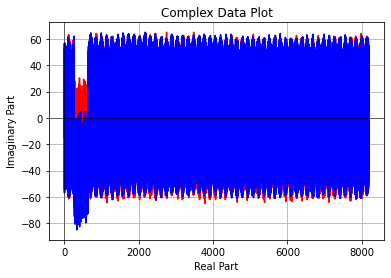

receiving request and sending sinusoid
getting data
request received, sending probe
create spectrogram


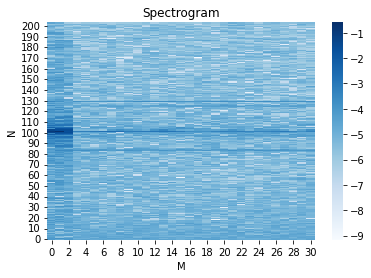

extract features
quantizing features
Extracted binary key: [0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0

In [15]:
radioAPI = "http://10.15.7.52:5002"
aiAPI = "http://127.0.0.1:5003"

freq = 2.4e9
samp_rate = 1e6
gainRX = 60
gainTX = 10
paramsTx = {"x":"tx","freq":freq,"SamplingRate":samp_rate,"gain":gainTX}
paramsRx = {"x":"rx","freq":paramsTx["freq"],"SamplingRate":int(paramsTx["SamplingRate"]),"gain":gainRX}
params = {"tx":paramsTx,"rx":paramsRx}

key = keyGeneration_Bob(radioAPI,aiAPI,params)
#key = keyGeneration_Alice(radioAPI,aiAPI,params)
print(key)

In [ ]:
data_received = receive_encrypted_data(radioAPI,key)

In [14]:
data = "ENGINEERING THE DAY AT FAU"
send_encrypted_data(radioAPI,key,data)

Encrypting data
Encrypted data: gAAAAABnG-eqzvt4uIThDPw6zvj9qoO1dQdSrtpsz1KL5LCgQuRjHiXilw_0BuF6JJLiEwKYQ4UZlvIeAhXmqSF4_SBKNz3DJ1nLh6h5tDcdPGeYpQ5QTZc=
Sending encrypted data
